**18장 – 강화 학습**

_이 노트북에는 18장의 모든 샘플 코드와 연습 문제에 대한 해결책이 포함되어 있습니다._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/handson-ml3/blob/main/18_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 설정

이 프로젝트에는 Python 3.7 이상이 필요합니다:

In [123]:
import sys

assert sys.version_info >= (3, 7)

그리고 TensorFlow ≥ 2.8:

In [124]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

이전 챕터에서 했던 것처럼 그림을 더 예쁘게 만들기 위해 기본 글꼴 크기를 정의해 보겠습니다. 또한 Matplotlib 애니메이션을 표시하기 위한 몇 가지 가능한 옵션이 있는데, 여기서는 Javascript 옵션을 사용하겠습니다.

In [125]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

그리고 `images/rl` 폴더를 만들고(아직 존재하지 않는 경우), 이 노트북을 통해 책에 사용할 그림을 고해상도로 저장하는 데 사용되는 `save_fig()` 함수를 정의해 보겠습니다:

In [126]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

이 챕터는 GPU가 없으면 매우 느려질 수 있으므로 GPU가 있는지 확인하거나 그렇지 않으면 경고를 표시합니다:

In [127]:
if not tf.config.list_physical_devices('GPU'):
    print("GPU가 감지되지 않았습니다. 신경망은 GPU가 없으면 매우 느릴 수 있습니다.")
    if "google.colab" in sys.modules:
        print("런타임 > 런타임 유형 변경으로 이동하여 하드웨어 가속기를 GPU로 선택합니다.")

강화 학습을 위한 다양한 환경을 제공하는 Gymnasium 라이브러리를 설치해 보겠습니다. 또한 곧 사용하게 될 CartPole을 포함한 클래식 제어 환경과 연습에 필요한 Box2D 및 Atari 환경에 필요한 추가 라이브러리도 설치합니다.

**중요 노트**

* OpenAI는 Gym 라이브러리의 개발과 유지보수를 Farama 재단으로 넘겼습니다(https://farama.org/Announcing-The-Farama-Foundation). 라이브러리 이름은 Gymnasium으로 바뀌었습니다. OpenAI Gym을 쓰는 자리에 대신 사용할 수 있습니다. `gym` 대신 `gymnasium`을 설치하고 `import gymnasium as gym`을 실행하면 됩니다.
* 다음 셀을 실행하면 Atari ROM 라이선스에 동의하는 것입니다.

In [128]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium
    %pip install swig
    %pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]

# OpenAI ~짐~ Gymnasium 소개

이 노트북에서는 강화 학습 알고리즘을 개발하고 비교하기 위한 훌륭한 툴킷인 [gymnasium](https://github.com/Farama-Foundation/Gymnasium)을 사용할 것입니다. 이 도구는 학습 *에이전트*가 상호작용할 수 있는 다양한 환경을 제공합니다. 짐을 임포트하고 새로운 CartPole 환경을 만들어 보겠습니다:

In [129]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")

CartPole(버전 1)은 왼쪽이나 오른쪽으로 움직일 수 있는 카트와 그 위에 수직으로 놓인 막대로 구성된 매우 간단한 환경입니다. 에이전트는 카트를 왼쪽이나 오른쪽으로 움직여 막대를 똑바로 세워야 합니다.

**팁**: `gym.envs.registry`는 사용 가능한 모든 환경을 포함하는 디셔너리입니다:

In [130]:
# 추가 코드 - 처음 몇 개의 환경을 표시합니다.
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', '...']

등록된 값은 환경 사양입니다:

In [131]:
# 추가 코드 - CartPole-v1 환경의 사양을 보여줍니다.
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

`reset()` 메서드를 호출하여 환경을 초기화해 보겠습니다. 이 메서드는 관측값과 추가 정보를 포함할 수 있는 딕셔너리를 반환합니다. 둘 다 환경에 따라 다릅니다.

In [132]:
env.reset(seed=42)

(array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32),
 {})

In [133]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [134]:
info

{}

CartPole의 경우 각 관측값은 4개의 실수로 구성된 1D 넘파이 배열로, 카트의 수평 위치, 속도, 극의 각도(0 = 수직) 및 각속도를 나타냅니다.

환경은 `render()` 메서드를 호출하여 시각화할 수 있습니다. 환경을 생성할 때 `render_mode`를 `"rgb_array"`로 설정하면 넘파이 배열이 반환됩니다.

In [135]:
img = env.render()
img.shape  # 높이, 너비, 채널 (3 = 빨강, 초록, 파랑)

(400, 600, 3)

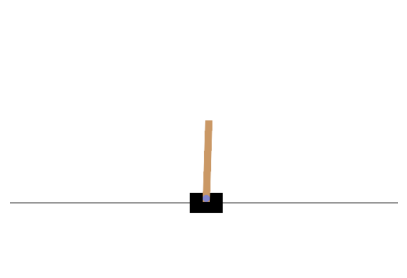

In [136]:
# 추가 코드 - 환경을 렌더링하고 플롯하는 작은 함수를 생성합니다.

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

환경과 상호 작용하는 방법을 살펴보겠습니다. 에이전트는 '행동 공간'(가능한 행동의 집합)에서 행동을 선택해야 합니다. 이 환경의 행동 공간이 어떻게 생겼는지 살펴보겠습니다:

In [137]:
env.action_space

Discrete(2)

네, 왼쪽(0)으로 가속하거나 오른쪽(1)으로 가속하는 두 가지 행동만 가능합니다.

막대가 오른쪽으로 기울어져 있으므로(`obs[2] > 0`) 카트를 오른쪽으로 가속해 봅시다:

In [138]:
action = 1  # 오른쪽 가속
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

이제 카트가 오른쪽으로 이동하고 있음을 알 수 있습니다(`obs[1] > 0`). 기둥은 여전히 오른쪽으로 기울어져 있지만(`obs[2] > 0`), 각속도는 이제 음수(`obs[3] < 0`)이므로 다음 스텝 이후에는 왼쪽으로 기울어질 가능성이 높습니다.

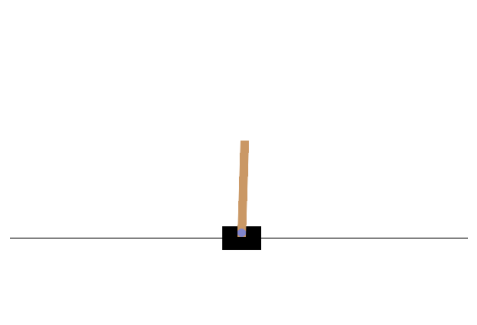

In [139]:
# 추가 코드 - 환경을 표시합니다.
plot_environment(env)
save_fig("cart_pole_plot")
plt.show()

우리가 시키는 대로 작동하는 것 같습니다!

환경은 에이전트에게 마지막 스텝에서 얼마나 많은 보상을 받았는지도 알려줍니다:

In [140]:
reward

1.0

게임이 끝나면 환경은 `done=True`를 반환합니다. 이 예시에서는 아직 끝나지 않았습니다:

In [141]:
done

False

일부 환경 래퍼는 환경을 조기에 중단하고 싶을 수 있습니다. 예를 들어, 시간 제한에 도달하거나 개체가 경계를 벗어난 경우입니다. 이 경우 `truncated`가 `True`로 설정됩니다. 이 예시에서는 아직 중단되지 않았습니다:

In [142]:
truncated

False

마지막으로 `info`는 디버깅이나 훈련에 유용할 수 있는 추가 정보를 제공하는 환경에 특화된 딕셔너리입니다. 예를 들어, 일부 게임에서는 에이전트의 생명력을 나타낼 수 있습니다.

In [143]:
info

{}

환경이 재설정되는 순간부터 완료되거나 잘릴 때까지의 일련의 단계를 "에피소드"라고 합니다. 에피소드가 끝날 때(즉, `step()`이 `done=True` 또는 `truncated=True`를 반환하는 경우) 환경을 계속 사용하기 전에 환경을 재설정해야 합니다.

In [144]:
if done or truncated:
    obs, info = env.reset()

이제 어떻게 하면 투표가 올바르게 유지될 수 있을까요? 이를 위해 _정책_ 을 정의해야 합니다. 이는 에이전트가 각 단계에서 행동을 선택하는 데 사용할 전략입니다. 과거의 모든 행동과 관찰을 사용하여 수행할 행동을 결정할 수 있습니다.

# 간단한 하드코딩 정책

막대가 왼쪽으로 기울어지면 카트를 왼쪽으로 밀고, 그 반대의 경우도 오른쪽으로 밉니다. 이 방식이 작동하는지 알아보죠:

In [145]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

In [146]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(np.float64(41.698), np.float64(8.389445512070509), 24.0, 63.0)

예상대로 이 전략은 너무 기본적인 전략으로, 막대를 63 스텝 동안만 유지하는 것이 최선입니다. 에이전트가 막대를 200 스텝 동안 유지하면 이 환경이 해결된 것으로 간주됩니다.

하나의 에피소드를 시각화해 봅시다. Matplotlib 애니메이션에 대한 자세한 내용은 [Matplotlib 튜토리얼 노트북](tools_matplotlib.ipynb#Animations)에서 확인할 수 있습니다.

In [147]:
# 추가 코드 - 이 셀은 한 에피소드의 애니메이션을 표시합니다.

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)

분명히 시스템이 불안정하고 몇 번만 흔들리면 막대가 너무 기울어져 게임이 끝납니다. 이 보다 더 똑똑해져야 합니다!

# 신경망 정책

관측값을 입력으로 받고 각 관측값에 대해 취할 행동의 확률을 출력하는 신경망을 만들어 보겠습니다. 행동을 선택하기 위해 네트워크가 각 행동에 대한 확률을 추정해야 합니다. 그런 다음 예상 확률에 따라 무작위로 행동을 선택합니다. CartPole 환경의 경우 가능한 동작이 두 가지(왼쪽 또는 오른쪽)뿐이므로 출력 뉴런은 하나만 필요합니다. 액션 0(왼쪽)의 확률 `p`가 출력되며, 당연히 액션 1(오른쪽)의 확률은 `1 - p`가 됩니다.

In [148]:
import tensorflow as tf

tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

이 특정 환경에서는 각 관측에 환경의 전체 상태가 포함되어 있으므로 과거의 행동과 관측은 안전하게 무시할 수 있습니다. 숨겨진 상태가 있는 경우 환경의 숨겨진 상태를 유추하기 위해 과거의 행동과 관측을 고려해야 할 수 있습니다. 예를 들어, 환경이 카트의 위치만 알려주고 속도는 알려주지 않는다면 현재 속도를 추정하기 위해 현재 관측뿐만 아니라 이전 관측도 고려해야 합니다. 또 다른 예는 관측값에 잡음이 있는 경우로, 과거 몇 개의 관측값을 사용하여 가장 가능성이 높은 현재 상태를 추정할 수 있습니다. 이 문제는 간단합니다. 현재 관측에 노이즈가 없고 환경의 전체 상태를 담고 있습니다.

왜 단순히 가장 높은 확률을 가진 행동을 선택하는 것이 아니라 정책 네트워크에서 주어진 확률에 따라 무작위로 행동을 선택하는지 궁금하실 것입니다. 이 접근 방식을 통해 에이전트는 새로운 행동을 _탐험_ 하는 것과 잘 작동하는 것으로 알려진 액션을 _활용_ 하는 것 사이에서 적절한 균형을 찾을 수 있습니다. 비유를 들어보죠. 처음으로 레스토랑에 갔는데 모든 요리가 똑같이 매력적으로 보여서 무작위로 하나를 골랐다고 가정해 보겠습니다. 맛있다고 판명되면 다음에 주문할 확률을 높일 수 있지만, 그 확률을 100%로 높이면 안 됩니다. 그렇지 않으면 먹어본 요리보다 더 맛있을 수 있는 다른 요리를 절대 먹어보지 않게 될 것입니다.

신경망을 사용하여 왼쪽으로 이동할 확률을 구하는 작은 정책 함수를 작성한 다음, 이를 사용하여 하나의 에피소드를 실행해 보겠습니다:

In [149]:
# 추가 코드 - 주어진 정책 모델에 대한 애니메이션을 만드는 함수입니다.

def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0]
    return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(pg_policy)

네... 꽤 나쁩니다. 신경망은 더 잘하는 법을 배워야 할 것입니다. 먼저 막대가 왼쪽으로 기울어지면 왼쪽으로 이동하고 오른쪽으로 기울어지면 오른쪽으로 이동하는 기본 정책을 학습할 수 있는지 살펴봅시다.

스스로 더 나은 정책을 학습할 수 있는지 살펴봅시다. 너무 막대가 흔들리지 않는 정책 말입니다.

# 정책 그레이디언트

이 신경망을 훈련하려면 타깃 확률 **y**를 정의해야 합니다. 어떤 행동이 좋으면 그 확률을 높이고, 반대로 나쁘면 확률을 낮춰야 합니다. 하지만 어떤 행동이 좋은지 나쁜지 어떻게 알 수 있을까요? 문제는 대부분의 행동이 지연 효과가 있기 때문에 에피소드에서 점수를 얻거나 잃을 때 어떤 행동이 이 결과에 기여했는지, 즉 마지막 행동이었는지 아니면 마지막 10개 행동이었는지 명확하지 않다는 것입니다. 아니면 마지막 10 스텝? 아니면 50 스텝 전의 행동 하나만 영향을 미쳤나요? 이를 _신용 할당 문제_ 라고 합니다.

_정책 그레이디언트_ 알고리즘은 먼저 여러 에피소드를 플레이한 다음, 양의 보상에 가까운 행동은 약간 더 높은 확률로, 음의 보상에 가까운 행동은 약간 더 낮은 확률로 만들어 이 문제를 해결합니다. 먼저 플레이한 다음 다시 돌아가서 자신이 한 행동에 대해 생각합니다.

모델을 사용하여 한 스텝을 재생하는 함수를 만들어 보겠습니다. 또한 손실과 그레이디언트를 계산할 수 있도록 지금은 어떤 행동을 선택하든 올바른 행동인 것처럼 가정합니다. 지금은 이 그레이디언트를 저장하고 나중에 행동이 얼마나 좋은지 나쁜지에 따라 수정하겠습니다.

In [150]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

`left_proba`이 높으면 `action`은 `False`일 가능성이 높습니다(0과 1 사이에서 균일하게 샘플링된 난수는 아마도 `left_proba`보다 크지 않을 것이기 때문입니다). 그리고 `False`는 숫자로 변환할 때 0을 의미하므로 `y_target`은 1 - 0 = 1이 됩니다. 즉, 타깃을 1로 설정하여 왼쪽으로 갈 확률이 100%여야 한다고 가정하고 올바른 행동을 취한 것입니다.

이제 `play_one_step()` 함수에 의존하여 여러 에피소드를 재생하고 각 에피소드와 각 단계에 대해 모든 보상과 그레이디언트를 반환하는 또 다른 함수를 만들어 보겠습니다:

In [151]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

정책 그레이디언트 알고리즘은 모델을 사용하여 에피소드를 여러 번(예: 10회) 재생한 다음 다시 돌아가서 모든 보상을 살펴보고 할인한 후 정규화합니다. 첫 번째 함수는 할인된 보상을 계산하고, 두 번째 함수는 여러 에피소드에 걸쳐 할인된 보상을 정규화합니다.

In [152]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

3개의 행동이 있고 각 행동 후에 보상을 받습니다. 처음 10, 그다음 0, -50이라고 가정해 보겠습니다. 80%의 할인율을 적용하면 세 번째 행동은 -50(마지막 보상에 대한 전체)을 받지만 두 번째 행동은 -40(마지막 보상에 대한 80%)만 받고, 첫 번째 행동은 -40의 80%(-32)에 첫 번째 보상에 대한 전체 크레딧(+10)을 더하여 -22의 할인된 보상을 받게 됩니다:

In [153]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

모든 에피소드에서 할인된 모든 보상을 정규화하기 위해 모든 할인된 보상의 평균과 표준 편차를 계산하고 각 할인된 보상에서 평균을 빼고 표준 편차로 나눕니다:

In [154]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [155]:
# 코랩의 메모리 부족을 피하기 위해 반복 횟수를 150에서 75로 수정
n_iterations = 75
# 코랩의 메모리 부족을 피하기 위해 에포크 횟수를 10에서 5로 수정
n_episodes_per_update = 5
n_max_steps = 200
discount_factor = 0.95

In [156]:
# 추가 코드 - 재현성을 위해 신경망을 생성하고 환경을 재설정해 보겠습니다.

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

obs, info = env.reset(seed=42)

In [157]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

In [ ]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # 추가 코드 - 훈련 중 일부 디버그 정보를 표시합니다.
    total_rewards = sum(map(sum, all_rewards))
    print(f"\r반복: {iteration + 1}/{n_iterations},"
          f" 평균 보상: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

반복: 22/75, 평균 보상: 91.8

In [ ]:
# 추가 코드 - 애니메이션을 표시합니다.
np.random.seed(42)
show_one_episode(pg_policy)

# 추가 자료 - 마르코프 연쇄

다음 전이 확률은 그림 18-7에 표시된 마르코프 연쇄에 해당합니다. 이 확률적 프로세스를 몇 번 실행하여 어떤 모습인지 확인해 보겠습니다:

In [ ]:
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # s0에서 s0, s1, s2, s3로
        [0.0, 0.0, 0.9, 0.1],  # s1에서 s0, s1, s2, s3로
        [0.0, 1.0, 0.0, 0.0],  # s2에서 s0, s1, s2, s3로
        [0.0, 0.0, 0.0, 1.0]]  # s3에서 s0, s1, s2, s3로

n_max_steps = 1000  # 무한 루프 발생을 방지합니다.
terminal_states = [3]

def run_chain(start_state):
    current_state = start_state
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state in terminal_states:
            break
        current_state = np.random.choice(
            range(len(transition_probabilities)),
            p=transition_probabilities[current_state]
        )
    else:
        print("...", end="")

    print()

for idx in range(10):
    print(f"실행 #{idx + 1}: ", end="")
    run_chain(start_state=0)

# 마르코프 결정 과정

몇 가지 전이 확률, 보상 및 가능한 행동을 정의해 보겠습니다. 예를 들어, 상태 s0에서 행동 a0을 선택하면 확률 0.7로 보상이 +10인 상태 s0으로 이동하고, 확률 0.3으로 보상이 없는 상태 s1로 이동하며, 보상이 없는 상태 s2로 이동하지 않습니다(따라서 전이 확률은 `[0.7, 0.3, 0.0]`이고 보상은 `[+10, 0, 0]`입니다):

In [ ]:
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

# Q-가치 반복

In [ ]:
Q_values = np.full((3, 3), -np.inf)  # 불가능한 동작의 경우 -np.inf
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # 가능한 모든 행동

In [ ]:
gamma = 0.90  # 할인 계수

history1 = []  # 추가 코드 - 아래 그림에 필요
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # 추가 코드
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                for sp in range(3)])

history1 = np.array(history1)  # 추가 코드

In [ ]:
Q_values

In [ ]:
Q_values.argmax(axis=1)  # 각 상태에 대한 최적의 행동

할인 계수 0.90을 사용할 때 이 MDP에 대한 최적의 정책은 상태 s0에 있을 때는 행동 a0을 선택하고, 상태 s1에 있을 때는 행동 a0을 선택한 다음, 마지막으로 상태 s2에 있을 때는 행동 a1(가능한 유일한 행동)을 선택하는 것입니다. 할인 계수를 0.90이 아닌 0.95로 설정하여 다시 시도하면 상태 s1에 대한 최적의 행동이 a2가 된다는 것을 알 수 있습니다. 이는 할인 계수가 더 커서 에이전트가 미래를 더 중요하게 여기기 때문에 더 많은 미래 보상을 받기 위해 즉각적인 페널티를 지불할 준비가 되어 있기 때문입니다.

# Q-러닝

Q-러닝은 에이전트의 플레이를 지켜보면서(예: 무작위로) Q-가치 추정치를 점진적으로 개선하는 방식으로 작동합니다. Q-가치 추정치가 정확해지면(또는 충분히 근접하면) 최적의 정책은 Q-가치가 가장 높은 행동(즉, 탐욕스러운 정책)을 선택하는 것입니다.

환경 내에서 에이전트가 움직이는 것을 시뮬레이션해야 하므로 몇 가지 행동을 수행하고 새로운 상태와 보상을 얻는 함수를 정의해 보겠습니다:

In [100]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

또한 가능한 모든 상태를 여러 번 방문하기만 하면 어떤 정책이라도 될 수 있는 탐험 정책이 필요합니다. 여기서는 상태 공간이 매우 작기 때문에 무작위 정책을 사용하겠습니다:

In [101]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

이제 앞서와 같이 Q-가치를 초기화하고 Q-러닝 알고리즘을 실행해 보겠습니다:

In [102]:
# 추가 코드 - 이전과 마찬가지로 Q-가치를 초기화합니다.
np.random.seed(42)
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

In [103]:
alpha0 = 0.05  # 초기 학습률
decay = 0.005  # 학습률 감쇠
gamma = 0.90  # 할인 계수
state = 0  # 초기 상태
history2 = []  # 추가 코드 - 아래 그림에 필요

for iteration in range(10_000):
    history2.append(Q_values.copy())  # 추가 코드
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()  # 다음 단계에서 탐욕 정책
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)  # 추가 코드

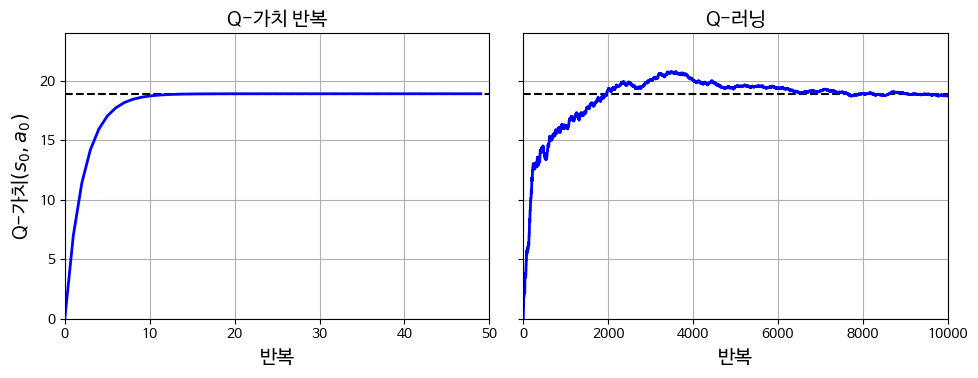

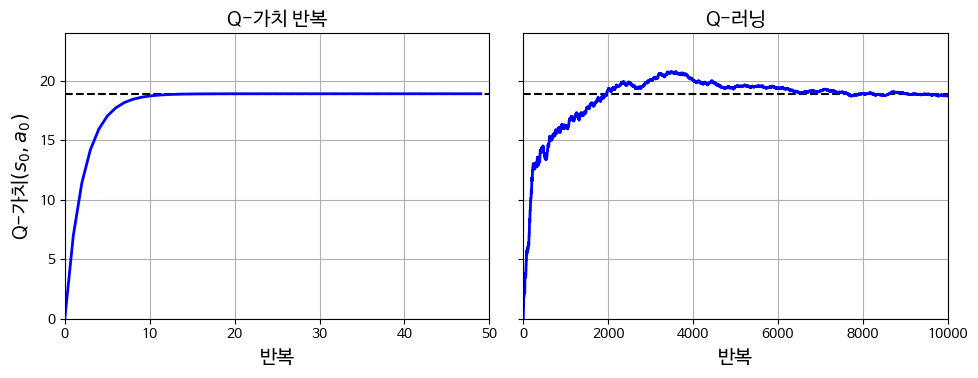

In [104]:
# extra code – this cell generates and saves Figure 18–9

true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-가치$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-가치 반복", fontsize=14)
axes[1].set_title("Q-러닝", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("반복", fontsize=14)
    ax.axis([0, width, 0, 24])
    ax.grid(True)

save_fig("q_value_plot")
plt.show()

# 심층 Q-네트워크

DQN을 구축해 봅시다. 상태가 주어지면 가능한 각 행동에 대해 해당 행동을 수행한 후(결과가 나오기 전) 기대할 수 있는 할인된 미래 보상의 합을 추정합니다:

In [105]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

input_shape = [4]  # == env.observation_space.shape
n_outputs = 2  # == env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


이 DQN을 사용하여 작업을 선택하려면 예측된 Q-가치가 가장 큰 행동을 선택하기만 하면 됩니다. 그러나 에이전트가 환경을 탐색하도록 보장하기 위해 확률 `epsilon`으로 랜덤한 행동을 선택합니다.

In [106]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # 랜덤 행동
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()  # DQN에 따른 최적의 행동

재생 버퍼도 필요합니다. 여기에는 에이전트의 경험이 튜플 형태로 포함됩니다: `(obs, action, reward, next_obs, done)`. 이를 위해 `deque` 클래스를 사용할 수 있습니다:

In [107]:
from collections import deque

replay_buffer = deque(maxlen=2000)

**참고**: 매우 큰 재생 버퍼의 경우 원형 버퍼를 대신 사용하는 것이 좋을 수 있습니다. 랜덤 액세스 시간이 O(N)이 아닌 O(1)이 되기 떄문입니다. 또는 딥마인드의 [Reverb 라이브러리](https://github.com/deepmind/reverb)를 확인해 보세요.

In [108]:
# 추가 코드 - 기본 원형 버퍼 구현

class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

그리고 재생 버퍼에서 경험을 샘플링하는 함수를 만들어 보겠습니다. 6개의 넘파이 배열을 반환합니다: `[obs, actions, rewards, next_obs, dones, truncateds]`.

In [109]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

이제 DQN을 사용하여 한 스텝을 재생하고 그 경험을 재생 버퍼에 기록하는 함수를 만들 수 있습니다:

In [110]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

마지막으로 재생 버퍼에서 일부 경험을 샘플링하고 훈련 스텝을 수행하는 함수를 만들어 보겠습니다:

In [111]:
# 추가 코드 - 재현성 및 다음 그림을 생성하기 위한 것입니다.
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

In [114]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.MeanSquaredError


def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # 에피소드가 완료되지 않거나 중단되지 않음
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

이제 모델을 훈련시켜 보겠습니다!

In [115]:
# 코랩에서 메모리 부족을 피하기 위해 에피소드 횟수를 600에서 300으로 줄입니다.
for episode in range(300):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # 추가 코드 - 디버그 정보를 표시하고, 다음 그림을 위한 데이터를 저장하며,
    #           지금까지 최고의 모델 가중치를 추적합니다.
    print(f"\r에피소드: {episode + 1}, 스텝: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)  # 추가 코드 - 최상의 모델 가중치를 복원합니다.

에피소드: 52, 스텝: 22, eps: 0.898

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

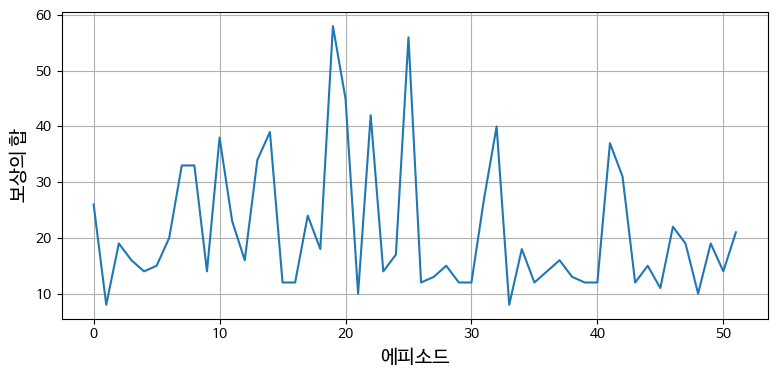

In [116]:
# 추가 코드 - 이 셀은 그림 18-10을 생성하고 저장합니다.
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("에피소드", fontsize=14)
plt.ylabel("보상의 합", fontsize=14)
plt.grid(True)
save_fig("dqn_rewards_plot")
plt.show()

In [117]:
# 추가 코드 - 훈련된 DQN이 한 에피소드를 재생하는 애니메이션을 보여줍니다.
show_one_episode(epsilon_greedy_policy)

전혀 나쁘지 않아요! 😀

## 고정 Q-가치 타깃

온라인 DQN을 만들어 보겠습니다:

In [118]:
# 추가 코드 - 이전과 동일한 DQN 모델을 생성합니다.

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


이제 대상 DQN을 생성합니다. 이는 그냥 온라인 DQN의 복제본입니다:

In [119]:
target = tf.keras.models.clone_model(model)  # 모델의 아키텍처 복제
target.set_weights(model.get_weights())  # 가중치 복사

다음으로 `# <= 변경됨`으로 표시된 줄을 제외하고 위와 동일한 코드를 사용합니다:

In [121]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

replay_buffer = deque(maxlen=2000)  # 재생 버퍼를 초기화합니다.

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = target.predict(next_states, verbose=0)  # <= 변경됨
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # 에피소드가 완료되지 않거나 중단되지 않음
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

AttributeError: module 'keras._tf_keras.keras.losses' has no attribute 'mean_squared_error'

여기에서도 `# <= 변경됨`으로 표시된 줄을 제외하고는 이전과 동일한 코드입니다:

In [ ]:
# 코랩에서 메모리 부족을 피하기 위해 에피소드 횟수를 600에서 300으로 줄입니다.
for episode in range(300):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # 추가 코드 - 디버그 정보를 표시하고, 다음 그림을 위한 데이터를 저장하며,
    #           지금까지 최고의 모델 가중치를 추적합니다.
    print(f"\r에피소드: {episode + 1}, 스텝: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:                        # <= 변경됨
            target.set_weights(model.get_weights())  # <= 변경됨

    # 또는 각 스텝에서 소프트 업데이트를 수행할 수도 있습니다:
    #if episode > 50:
        #training_step(batch_size)
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index, online_weight in enumerate(online_weights):
        #    target_weights[index] = (0.99 * target_weights[index]
        #                             + 0.01 * online_weight)
        #target.set_weights(target_weights)

model.set_weights(best_weights)  # 추가 코드 - 최상의 모델 가중치를 복원합니다.

In [ ]:
# 추가 코드 - 이 셀은 학습 곡선을 표시합니다.
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("에피소드", fontsize=14)
plt.ylabel("보상의 합", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# 추가 코드 - 훈련된 DQN이 한 에피소드를 재생하는 애니메이션을 보여줍니다.
show_one_episode(epsilon_greedy_policy)

## 더블 DQN

코드는 `training_step()` 함수에서 `변경된 섹션`을 제외하고는 고정 Q-가치 타깃의 경우와 완전히 동일합니다:

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

target = tf.keras.models.clone_model(model)  # 모델의 아키텍처 복제
target.set_weights(model.get_weights())  # 가중치 복사

env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences

    #################### 변경된 섹션 ####################
    next_Q_values = model.predict(next_states, verbose=0)  # ≠ target.predict()
    best_next_actions = next_Q_values.argmax(axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask
                        ).sum(axis=1)
    #########################################################

    runs = 1.0 - (dones | truncateds)  # 에피소드가 완료되지 않거나 중단되지 않음
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

replay_buffer = deque(maxlen=2000)

# 코랩에서 메모리 부족을 피하기 위해 에피소드 횟수를 600에서 300으로 줄입니다.
for episode in range(300):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\r에피소드: {episode + 1}, 스텝: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

In [ ]:
# 추가 코드 - 이 셀은 학습 곡선을 표시합니다.
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("에피소드", fontsize=14)
plt.ylabel("보상의 합", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# 추가 코드 - 훈련된 DQN이 한 에피소드를 재생하는 애니메이션을 보여줍니다.
show_one_episode(epsilon_greedy_policy)

# 듀얼링 더블 DQN

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

input_states = tf.keras.layers.Input(shape=[4])
hidden1 = tf.keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = tf.keras.layers.Dense(32, activation="elu")(hidden1)
state_values = tf.keras.layers.Dense(1)(hidden2)
raw_advantages = tf.keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - tf.reduce_max(raw_advantages, axis=1,
                                            keepdims=True)
Q_values = state_values + advantages
model = tf.keras.Model(inputs=[input_states], outputs=[Q_values])

나머지는 이전과 동일한 코드입니다:

In [ ]:
# 추가 코드 - 모델 훈련

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-3)
loss_fn = tf.keras.losses.mean_squared_error

target = tf.keras.models.clone_model(model)  # 모델의 아키텍처 복제
target.set_weights(model.get_weights())  # 가중치 복사

env.reset(seed=42)
replay_buffer = deque(maxlen=2000)
rewards = []
best_score = 0

# 코랩에서 메모리 부족을 피하기 위해 에피소드 횟수를 600에서 300으로 줄입니다.
for episode in range(300):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\r에피소드: {episode + 1}, 스텝: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

In [ ]:
# 추가 코드 - 이 셀은 학습 곡선을 표시합니다.
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("에피소드", fontsize=14)
plt.ylabel("보상의 합", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# 추가 코드 - 훈련된 DQN이 한 에피소드를 재생하는 애니메이션을 보여줍니다.
show_one_episode(epsilon_greedy_policy)

꽤 안정된 에이전트처럼 보입니다!

In [ ]:
env.close()

# 연습문제 해답

## 1. to 7.

부록 A 참조.

## 8.
_문제: 정책 그레이디언트를 사용해 ~OpenAI 짐~ Gymnasium의 LunarLander-v2 환경을 해결해보세요._

먼저 LunarLander-v2 환경을 만들어 보죠:

In [122]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment LunarLander-v2 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(


DeprecatedEnv: Environment version v2 for `LunarLander` is deprecated. Please use `LunarLander-v3` instead.

입력은 8차원입니다:

In [ ]:
env.observation_space

In [ ]:
obs, info = env.reset(seed=42)
obs

[소스 코드](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/box2d/lunar_lander.py)를 보면 8D 관측(x, y, h, v, a, w, l, r)이 각각 다음에 해당합니다:
* x,y: 우주선의 좌표. (0, 1.4) 근처의 랜덤한 위치에서 시작하고 (0, 0)에 있는 목적지 근처에 내려야 합니다.
* h,v: 우주선의 수평, 수직 속도. 랜덤한 적은 속도로 시작합니다.
* a,w: 우주선의 각도와 각속도.
* l,r: 왼쪽이나 오른쪽 다리가 땅에 닿았는지(1.0) 아닌지(0.0) 여부.

행동 공간은 이산적이며 4개의 가능한 행동이 있습니다:

In [ ]:
env.action_space

[LunarLander-v2 설명](https://gymnasium.farama.org/environments/box2d/lunar_lander/)을 보면 이 행동은 다음과 같습니다:
* 아무것도 하지 않음
* 왼쪽 방향 엔진을 켬
* 주 엔진을 켬
* 오른쪽 방향 엔진을 켬

(행동마다 하나씩) 4개의 출력 뉴런을 가진 간단한 정책 네트워크를 만들어 보죠:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu", input_shape=[n_inputs]),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(n_outputs, activation="softmax"),
])

출력 층에 CartPole-v1 환경처럼 시그모이드 활성화 함수를 사용하지 않고 대신에 소프트맥스 활성화 함수를 사용합니다. CartPole-v1 환경은 두 개의 행동만 있어서 이진 분류 모델이 맞기 때문입니다. 하지만 두 개 이상의 행동이 있으므로 다중 분류 모델이 됩니다.

그다음 CartPole-v1 정책 그레이디언트 코드에서 정의한 `play_one_step()`와 `play_multiple_episodes()` 함수를 재사용합니다. 하지만 다중 분류 모델에 맞게 `play_one_step()`를 조금 수정하겠습니다. 그다음 수정된 `play_one_step()` 를 호출하고, 우주선이 최대 스텝 횟수 전에 랜딩하지 못하면 (또는 부서지면) 큰 페널티를 부여하도록 `play_multiple_episodes()` 함수를 수정합니다.

In [ ]:
def lander_play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + tf.keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        loss = tf.reduce_mean(loss_fn(action, probas))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info, truncated = env.step(action[0, 0].numpy())
    return obs, reward, done, truncated, grads

def lander_play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = lander_play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

앞에서와 동일한 `discount_rewards()`와 `discount_and_normalize_rewards()` 함수를 사용합니다:

In [ ]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

이제 몇 개의 하이퍼파라미터를 정의합니다:

In [ ]:
# 코랩의 메모리 부족을 피하기 위해 반복 횟수를 200에서 50으로 수정
n_iterations = 50
n_episodes_per_update = 16
# 코랩의 메모리 부족을 피하기 위해 최대 스텝 횟수를 1000에서 200으로 수정
n_max_steps = 200
discount_factor = 0.99

여기서도 다중 분류 모델이기 때문에 이진 크로스 엔트로피가 아니라 범주형 크로스 엔트로피를 사용해야 합니다. 또한 `lander_play_one_step()` 함수가 클래스 확률이 아니라 클래스 레이블로 타깃을 설정하기 때문에 `sparse_categorical_crossentropy()` 손실 함수를 사용해야 합니다:

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.005)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy

모델을 훈련할 준비가 되었네요. 시작해 보죠!

In [ ]:
env.reset(seed=42)

mean_rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = lander_play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print(f"\r반복: {iteration + 1}/{n_iterations},"
          f" 평균 보상: {mean_reward:.1f}  ", end="")
    mean_rewards.append(mean_reward)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

학습 곡선을 그려 보겠습니다:

In [ ]:
plt.plot(mean_rewards)
plt.xlabel("에피소드")
plt.ylabel("평균 보상")
plt.grid()
plt.show()

결과를 확인해 보죠!

In [ ]:
def lander_render_policy_net(model, n_max_steps=500, seed=42):
    frames = []
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    tf.random.set_seed(seed)
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + tf.keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        obs, reward, done, truncated, info = env.step(action[0, 0].numpy())
        if done or truncated:
            break
    env.close()
    return frames

In [ ]:
frames = lander_render_policy_net(model, seed=42)
plot_animation(frames)

꽤 괜찮군요. 더 오래 훈련하거나 하이퍼파라미터를 튜닝하여 200을 넘을 수 있는지 확인해 보세요.

## 9.
_문제: 더블 듀얼링 DQN을 사용하여 유명한 아타리 브레이크아웃(Breakout) 게임(`"ALE/Breakout-v5"`)에서 사람의 수준을 뛰어 넘을 수 있는 에이전트를 훈련해 보세요. 관측은 이미지입니다. 작업을 단순화하기 위해 흑백으로 변환(즉, 채널 축을 따라 평균)합니다. 그다음 재생할 수 있을 만큼 크지만 그 이상되지 않도록 자르고 다운샘플링합니다. 개별 이미지만으로는 공과 패들(paddle)이 어느 방향으로 가고 있는지 알 수 없으므로 두세 개의 연속된 이미지를 병합하여 각 상태를 만들어야 합니다. 마지막으로 DQN은 합성곱 층으로 대부분 구성되어야 합니다._

TODO

[paperswithcode.com에서 아타리 게임의 최신 기술](https://paperswithcode.com/task/atari-games)을 확인하세요.

## 10.
_문제: 10만 원 정도 여유가 있다면 라즈베리 파이 3와 저렴한 로보틱스 구성품을 구입해 텐서플로를 설치하고 실행할 수 있습니다! 예를 들어 루카스 비월드의 재미있는 [포스트](https://homl.info/2)를 참고하거나, GoPiGo42나 BrickPi43를 둘러보세요. 간단한 작업부터 시작해보세요. 예를 들어 (조도 센서가 있다면) 로봇이 밝은 쪽으로 회전하거나 (초음파 센서가 있다면) 가까운 물체가 있는 쪽으로 움직이도록 해보세요. 그다음 딥러닝을 사용해보세요. 예를 들어 로봇에 카메라가 있다면 객체 탐지 알고리즘을 구현해 사람을 감지하고 가까이 다가가게 만들 수 있습니다. 강화 학습을 사용해 목표를 달성하기 위해 모터 사용법을 스스로 학습할 수도 있습니다._

이제 여러분 차례입니다. 도전적이고 창의적으로, 무엇보다도 인내심을 가지고 한 발씩 나아가세요. 여러분은 할 수 있습니다!